In [1]:
# %%
import sys
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
from keras.models import Sequential,load_model
from keras.layers import Dense, Activation, LSTM, Dropout, RepeatVector, TimeDistributed, Bidirectional, GRU, Conv2D, MaxPooling2D, Flatten, Reshape, Conv1D, MaxPooling1D
from keras import activations
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from functions import *
import tensorflow.keras as keras

IndexError: list index out of range

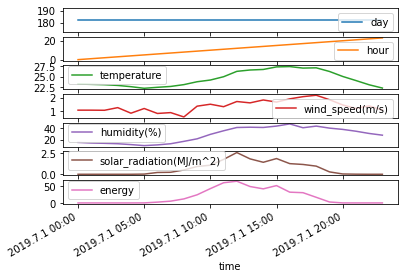

In [2]:
data = pd.read_csv('../Data/ProductionData/Weather-Energy_rev_time_hourly_data.csv')

cols = ['day','hour','temperature','wind_speed(m/s)','humidity(%)','solar_radiation(MJ/m^2)','energy']
dataset = data.loc[:, cols]

dataset.index = data['time']



# Generate data to predict January 31st energy production
start = data[data['time']=="2019-07-01 0:00"].index.tolist()[0]
end = data[data['time']=="2020-01-31 0:00"].index.tolist()[0]# %%
# use previous 4days to predict future 24hours
trainX_131, trainY_131 = generate_training_data_hourly(start, end, 4, 24, 1, dataset)


start2 = data[data['time']=="2020-02-01 0:00"].index.tolist()[0]
end2 = data[data['time']=="2020-03-31 0:00"].index.tolist()[0]
trainX_331, trainY_331 = generate_training_data_hourly(start2, end2, 4, 24, 1, dataset)

start3 = data[data['time']=="2020-04-01 0:00"].index.tolist()[0]
end3 = data[data['time']=="2020-05-31 0:00"].index.tolist()[0]
trainX_531, trainY_531 = generate_training_data_hourly(start3, end3, 4, 24, 1, dataset)

start4 = data[data['time']=="2020-06-01 0:00"].index.tolist()[0]
end4 = data[data['time']=="2020-06-30 21:00"].index.tolist()[0]
trainX_701, trainY_701 = generate_training_data_hourly(start4, end4, 4, 24, 1, dataset)

In [ ]:
# not necessary
dataset['humidity(%)'] = 100 - dataset['humidity(%)']  

dataset[:24].plot(subplots = True)

scaler_y = StandardScaler()
scaler = StandardScaler()
# scaler_y = MinMaxScaler()
# scaler = MinMaxScaler()
y = np.expand_dims(dataset[cols[-1]], axis = 1)
y = scaler_y.fit_transform(y)

dataset = scaler.fit_transform(dataset)

In [156]:
trainY_131.shape

(5016, 24, 1)

In [157]:
trainY_331.shape

(1296, 24, 1)

In [158]:
trainY_531.shape

(1320, 24, 1)

In [159]:
trainY_701.shape

(597, 24, 1)

In [160]:
# make total training dataset
trainX = np.concatenate((trainX_131, trainX_331, trainX_531, trainX_701))
trainY = np.concatenate((trainY_131, trainY_331, trainY_531, trainY_701))

In [161]:
# model 세이브를 위한 데이터; 모델을 저장하기 위해 한번의 피팅이 필요
x_train, y_train, x_val, y_val = split_data(trainX_131[:-24*7], trainY_131[:-24*7], 0.1)

In [163]:
model1 = Sequential()
# trinaX_YY1.shape = (None, 96, 7)
model1.add(GRU(units=128, activation='relu', return_sequences=True, input_shape=trainX_331.shape[-2:]))
model1.add(GRU(units=64, activation='relu', return_sequences=False))
model1.add(RepeatVector(trainY_331.shape[1]))
model1.add(GRU(units=64, activation='relu', return_sequences=True))
model1.add(GRU(units=128, activation='relu', return_sequences=True))
model1.add(TimeDistributed(Dense(1)))
model1.compile(loss='mse', optimizer='adam', metrics= [custom_loss])

model1.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_13 (GRU)                 (None, 96, 128)           52224     
_________________________________________________________________
gru_14 (GRU)                 (None, 64)                37056     
_________________________________________________________________
repeat_vector_3 (RepeatVecto (None, 24, 64)            0         
_________________________________________________________________
gru_15 (GRU)                 (None, 24, 64)            24768     
_________________________________________________________________
gru_16 (GRU)                 (None, 24, 128)           74112     
_________________________________________________________________
time_distributed_3 (TimeDist (None, 24, 1)             129       
Total params: 188,289
Trainable params: 188,289
Non-trainable params: 0
________________________________________________

In [164]:
model1.save('gru.h5')

In [165]:
# Bidirectional LSTM model
# should do model.fit once to implement model.summary
model = Sequential()
# trinaX_YY1.shape = (None, 96, 7)
model.add(Bidirectional(LSTM(input_shape=trainX_331.shape[-2:], units=10, return_sequences=True)))
model.add(Bidirectional(LSTM(units=10, return_sequences=False)))
model.add(RepeatVector(trainY_331.shape[1]))
model.add(Bidirectional(LSTM(units=10, return_sequences=True)))
model.add(Bidirectional(LSTM(units=10, return_sequences=True)))
model.add(TimeDistributed(Dense(1)))
model.add(Activation(activations.relu))
model.compile(loss='mse', optimizer='adam', metrics= [custom_loss])



In [166]:
model.fit(x_train, y_train, batch_size=128, epochs=1, validation_data = (x_val,y_val), verbose = 0)
model.save('biLSTM.h5')

In [167]:
# one directional LSTM model
# should do model.fit once to implement model.summary
model2 = Sequential()
# trinaX_YY1.shape = (None, 96, 7)
model2.add((LSTM(input_shape=trainX_331.shape[-2:], units=10, return_sequences=False)))
model2.add(RepeatVector(trainY_331.shape[1]))
model2.add((LSTM(units=10, return_sequences=False)))
model2.add(RepeatVector(trainY_331.shape[1]))
model2.add((LSTM(units=10, return_sequences=True)))
model2.add((LSTM(units=10, return_sequences=True)))
model2.add(TimeDistributed(Dense(1)))
model2.add(Activation(activations.relu))
model2.compile(loss='mse', optimizer='adam', metrics= [custom_loss])

In [168]:
model2.fit(x_train, y_train, batch_size=128, epochs=1, validation_data = (x_val,y_val), verbose = 0)
model2.save('LSTM.h5')

In [171]:
# cnn-lstm model
# use 1 dimensional cnn 
model3 = Sequential()
model3.add(Reshape((96,7,1)))
model3.add(TimeDistributed(Conv1D(64, kernel_size= 2 , activation = 'relu', padding = 'valid')))
model3.add(TimeDistributed(MaxPooling1D(2, strides = 2)))
model3.add(TimeDistributed(Conv1D(64, kernel_size= 2, activation = 'relu', padding = 'valid')))
model3.add(TimeDistributed(MaxPooling1D(2, strides = 2)))
model3.add(TimeDistributed(Flatten()))
model3.add(Bidirectional(LSTM(units=64, return_sequences=False)))
model3.add(Dense(32))
model3.add(Dense(24, activation = 'relu'))
model3.add(Reshape((-1,1)))

model3.compile(loss='mse', optimizer='adam', metrics= [custom_loss])

In [172]:
model3.fit(x_train, y_train, batch_size=128, epochs=1, validation_data = (x_val,y_val), verbose = 0)
model3.save('cnn_lstm.h5')

In [173]:
import tensorflow.keras as keras

In [174]:
# load model
model = keras.models.load_model('gru.h5', custom_objects = {'custom_loss':custom_loss})
model1 = keras.models.load_model('biLSTM.h5', custom_objects = {'custom_loss':custom_loss})

In [175]:
Inputs = keras.Input(shape = trainX_331.shape[-2:])

y0 = model(Inputs)
y1 = model1(Inputs)
output = keras.layers.average([y0, y1])
ensemble_model = keras.Model(inputs=Inputs, outputs=output)

ensemble_model.compile(loss='mse', optimizer='adam')

In [176]:
ensemble_model.save('ens.h5')

In [177]:
end_131 = len(trainX_131)
end_331 = end_131 + len(trainX_331)
end_531 = end_331 + len(trainX_531)
end_701 = end_531 + len(trainX_701)

주의 ! fitting function은 callback의 종류에 따라서 model.fit의 변수를 다르게 해주어야됨.

In [200]:
# function to predict target day
# we don't have any data on 1.31, 3.31, 5.31
# generate training data hourly made only unitl 1.30, 3.30, 5.30
# thus, the maximum day we can predict and evlaute is abvoe three m.30 days
# this function predict the day and evaluate it.

# ex) end = end_131 , day = 1 -> predict 1.29 부터 7개
# ex) end = end_531, day = 2 -> predict 5.28 부터 7개
# ex) end = end_331 , day = 4 -> predict 3.26 부터 7개

def fitting(x, y, day, epoch, callbacks, model):
    # target day = max index - 1  - day
    
    target_day = end_131-1 - 24*day
    target_day2 = end_331-1 -24*day
    target_day3 = end_531-1 -24*day

    # make training data using after the target day+6일 and concatenate them
    x_train = np.concatenate((x[:target_day-24+1], x[target_day+24*7:target_day2-24+1], x[target_day2+24*7:target_day3-24+1], x[target_day3+24*7:] ))
    y_train = np.concatenate((y[:target_day-24+1], y[target_day+24*7:target_day2-24+1], y[target_day2+24*7:target_day3-24+1] , y[target_day3+ 24*7:]))
    # validation data is the target day ~ targetday+7 days
    x_val = np.concatenate((x[target_day:target_day+24*7], x[target_day2:target_day2+24*7], x[target_day3:target_day3+24*7]))
    y_val = np.concatenate((y[target_day:target_day+24*7], y[target_day2:target_day2+24*7], y[target_day3:target_day3+24*7]))
    # callbacks = callbacks_fst일 경우
    history = model.fit(x_train, y_train, batch_size=512, epochs=epoch, 
                         validation_data = (x_val, y_val), verbose = 1, callbacks = callbacks)
    #***************************************************#
#     # callbacks = callbacks_snd일 경우
#     history = model.fit(x, y, batch_size=512, epochs=epoch, 
#                          validation_data = (x_val, y_val), verbose = 1, callbacks = callbacks)

In [201]:
model = keras.models.load_model('ens.h5', custom_objects = {'custom_loss':custom_loss})

In [206]:
callbacks_fst = [keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=10, verbose=1, factor=0.6),
              keras.callbacks.EarlyStopping(monitor='val_loss', patience=20),
             keras.callbacks.ModelCheckpoint(filepath='best_ens_fst.h5', monitor='val_loss', save_best_only=True)]

callbacks_snd = [keras.callbacks.ReduceLROnPlateau(monitor='val_custom_loss', patience=10, verbose=1, factor=0.6),
              keras.callbacks.EarlyStopping(monitor='val_loss', patience=20),
             keras.callbacks.ModelCheckpoint(filepath='best_ens_snd.h5', monitor='val_loss', save_best_only=True)]

In [ ]:
fitting(trainX, trainY, day = 7, epoch = 100, callbacks = callbacks_fst , model  = model)

Epoch 1/100
15/15 [==============================] - 218s 15s/step - loss: 0.1553 - val_loss: 0.2511 - lr: 0.0010
Epoch 2/100
15/15 [==============================] - 213s 14s/step - loss: 0.1400 - val_loss: 0.2403 - lr: 0.0010
Epoch 3/100
15/15 [==============================] - 213s 14s/step - loss: 0.1328 - val_loss: 0.2288 - lr: 0.0010
Epoch 4/100
15/15 [==============================] - 211s 14s/step - loss: 0.1269 - val_loss: 0.2403 - lr: 0.0010
Epoch 5/100
15/15 [==============================] - 200s 13s/step - loss: 0.1294 - val_loss: 0.2378 - lr: 0.0010
Epoch 6/100
15/15 [==============================] - 188s 13s/step - loss: 0.1247 - val_loss: 0.2353 - lr: 0.0010
Epoch 7/100
15/15 [==============================] - 184s 12s/step - loss: 0.1157 - val_loss: 0.2526 - lr: 0.0010
Epoch 8/100
15/15 [==============================] - 183s 12s/step - loss: 0.1137 - val_loss: 0.2447 - lr: 0.0010
Epoch 9/100
15/15 [==============================] - 184s 12s/step - loss: 0.1110 - val_

In [ ]:
model = keras.models.load_model('best_ens_fst.h5', custom_objects = {'custom_loss':custom_loss})

fitting 함수를 수정한 후

In [133]:
fitting(trainX, trainY, end_131, day = 7, epoch = 5, callbacks = callbacks_snd , model  = model)

In [134]:
model = keras.models.load_model('best_ens_snd.h5', custom_objects = {'custom_loss':custom_loss})

OSError: SavedModel file does not exist at: best_ens_snd.h5/{saved_model.pbtxt|saved_model.pb}

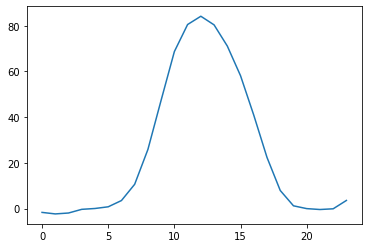

In [68]:
pred_531 = model.predict(np.expand_dims(dataset[end3-96:end3], axis = 0))
pred_531 = np.reshape(pred_531, pred_531.shape[-2:])
pred_531 = scaler_y.inverse_transform(pred_531)

plt.plot(pred_531)

In [69]:
print(pred_531)

array([[-1.6590941e+00],
       [-2.3228667e+00],
       [-1.9274008e+00],
       [-3.1986639e-01],
       [ 5.2406091e-02],
       [ 7.9115272e-01],
       [ 3.5257614e+00],
       [ 1.0643831e+01],
       [ 2.5884586e+01],
       [ 4.7463409e+01],
       [ 6.8723679e+01],
       [ 8.0558762e+01],
       [ 8.4177650e+01],
       [ 8.0399834e+01],
       [ 7.1142181e+01],
       [ 5.8141731e+01],
       [ 4.0880169e+01],
       [ 2.2390131e+01],
       [ 7.9332561e+00],
       [ 1.2237394e+00],
       [-3.7329004e-03],
       [-3.9653227e-01],
       [-8.3172061e-02],
       [ 3.5730808e+00]], dtype=float32)

In [70]:
# 트레이닝 데이터내에서 예측값과 정답값을 그래프로 표현
days = len(trainX)//24
for i in range(days-14,days-7):
    show_graph_t(i*24-1, model, trainX, trainY, scaler_y)

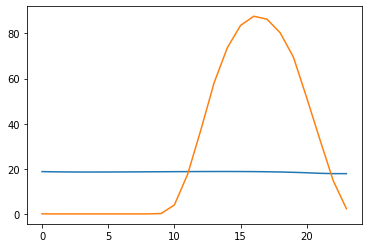

In [135]:
# 특정 트레이닝 데이터의 mse를 invere stransfrom 버전으로 계산
pred = scaler_y.inverse_transform(model.predict(trainX[20:21])).flatten()
ans = scaler_y.inverse_transform(trainY[20]).flatten()
plt.plot(pred)
plt.plot(ans)

In [114]:
pred = np.array(pred)
ans = np.array(ans)

In [112]:
((pred-ans)*(pred-ans)).mean()

In [142]:
time_split_trainX_131, time_split_trainY_131 = generate_training_data_hourly(start, end, 4, 24, 24, dataset)
time_split_trainX_331, time_split_trainY_331 = generate_training_data_hourly(start2, end2, 4, 24, 24, dataset)
time_split_trainX_531, time_split_trainY_531 = generate_training_data_hourly(start3, end3, 4, 24, 24, dataset)

time_split_trainX = np.concatenate((time_split_trainX_131, time_split_trainX_331, time_split_trainX_531))
time_split_trainY = np.concatenate((time_split_trainY_131, time_split_trainY_331, time_split_trainY_531))

In [136]:
from sklearn.model_selection import TimeSeriesSplit

# 10 fold
tscv = TimeSeriesSplit(10)

# %%
batch_size = 32
num_epochs = 40
verbosity = 2

# %%
loss_per_iter = []

# %%
X_seq = time_split_trainX
Y_seq = time_split_trainY

# %%
iter_num = 1
for train_idx, test_idx in tscv.split(X_seq):
    # 가중치가 무작위로 초기화된 모델을 불러옴.
    model = keras.models.load_model('seletmodel.h5', custom_objects = {'custom_loss':custom_loss})

    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for {iter_num} ...')
 
    # Fit data to model
    history = model.fit(X_seq[train_idx], Y_seq[train_idx],
              validation_data = (X_seq[test_idx], Y_seq[test_idx]),
              batch_size=batch_size,
              epochs=num_epochs,
              verbose=verbosity)
    
    # Generate generalization metrics
    scores = model.evaluate(X_seq[test_idx], Y_seq[test_idx], verbose=0)
    print(scores)
#     acc_per_iter.append(scores[1])
    loss_per_iter.append(scores)

    # Increase fold number
    iter_num = iter_num + 1

# %%
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per iteration')
for i in range(0, len(acc_per_iter)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_iter[i]}')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Loss: {np.mean(loss_per_iter)}')
print('------------------------------------------------------------------------')

 average mean of 10 fold evalutation
    
    1. gru: 0.37619040757417677    -> (20 epochs)
    
    2. gru + biLSTM: 0.3314497694373131   -> (20 epochs)
    
    3. gru + biLSTM + CNN-LSTM : 0.30              -> (40 epochs)
but 3 has low performance on actual training
